# Analyzing Data with Spark

AUBRIOT, Vincent
TEMPLIER, William

##  Overview

This notebook contains our analysis proposition for the LSDM project, that focuses on a dataset published by Google that contains activity and configuration information for 12.5k servers, over a long activity period (29 days).

During our study, we first focused on basic questions, in order to extract useful metrics and get used to how Spark works and what functions we can use to complete each task. Then, we proposed an extension.

## Basic analysis

We start by importing useful librairies, and launching pyspark.

In [1]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

# Parameters for the visualizations
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# For easy computation over certain datasets
import numpy as np
np.set_printoptions(suppress=True)

# Pyspark utilities
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Execution mode:
# Cluster = -1
# Local >= 1 (i.e., number of files to load)

EXEC_MODE = 1
cloud = False

# TODO
from lib import *

# start spark with 1 worker thread
sc = init()
sc.setLogLevel("ERROR")

# Start SparkSession to use DataFrames
spark = SparkSession(sc)

### What is the distribution of the machines according to their CPU capacity?

We first load the "machine events" file, as it contains information about all of the machines available in the system.
The goal is to count all occurences of each value recorded for the cpu, and from this, to output the global distribution of the CPU capacity for the entire system.

To load the file, we use a custom class which, from a given file, creates a RDD using the current spark context.
A partial output is done to confirm that we indeed have the information we need.

In [2]:
# Get the machine_events table from the GCloud bucket and use it with spark
machine_events = Table('machine_events', sc, EXEC_MODE, cloud)
machine_events.pprint(take=5)

,time,machine_id,event_type,platform_id,cpus,memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


We could confirm that the output contains the `cpus` property that interests us for each machine. We now compute the global distribution, and we visualize it as a pie chart.

In [3]:
# Count the number of occurences for each unique value found in the cpus field, and print it
cpu_dist = machine_events.select(['cpus']).countByValue()
print("Distribution of the machines according to their CPU capacity:")
for cpu_type, value in cpu_dist.items():
    print(f'\tCPU type: {cpu_type[0]}, count: {value}')

Distribution of the machines according to their CPU capacity:
	CPU type: 0.5, count: 35015
	CPU type: 0.25, count: 510
	CPU type: 1, count: 2223
	CPU type: NA, count: 32


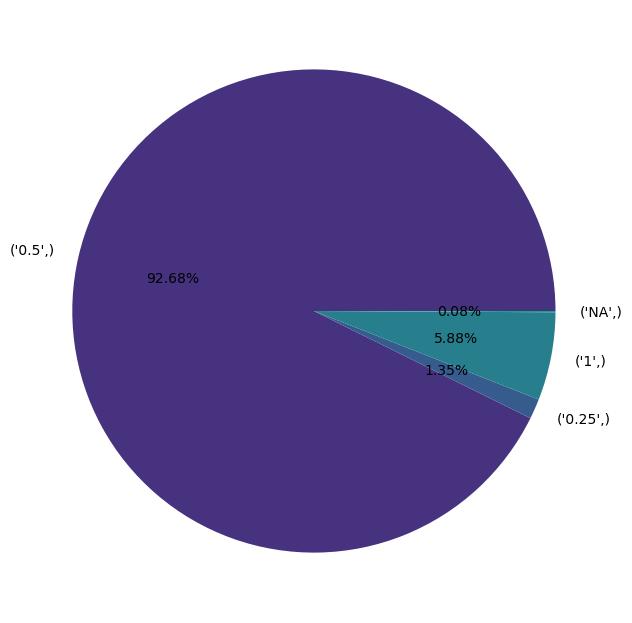

In [4]:
# Show it as a pie chart to have a clear representation of the cpus distribution across the entire set of machines
plt.pie(cpu_dist.values(), labels=cpu_dist.keys(), colors = colors, autopct='%.2f%%')
plt.show()

From the visualization shown above, we see that a large majority of the machines is using what would be called an "average" CPU (around 92 to 93% of the entire set). The remaining is mostly using a higher-end CPU (5 to 6%), and around 1% have a lower-end CPU. The data are missing for a few machines.

## Dataframe version

In [5]:
me = create_dataframe('machine_events', EXEC_MODE, cloud)

Will download at most 1 file(s) from machine_events.
Polling bucket gs://clusterdata-2011-2/machine_events
Dowloading [/part-00000-of-00001.csv.gz]
Successfully downloaded table [machine_events] (1/1).


In [6]:
me.groupBy('cpus').count().show()

+----+-----+
|cpus|count|
+----+-----+
|0.25|  510|
|  NA|   32|
| 0.5|35015|
|   1| 2223|
+----+-----+



### Cluster execution

As the `machine_events` table consists of only one file, executing *Job 1* on a cluster is meaningless: the overhead of paralellizing is greater than the gain it incurs.

**Time:**
* RDD local: 0.3 s
* RDD cluster: 16.64 s
* DF local: 3.3 s
* DF cluster: 7.96 s

??

# Job 2: on average, how many tasks compose a job?

Now, we focus on the jobs that were running during the analyzed period. We know that each job is composed of multiple tasks, but no information was provided about the average number of tasks in a single job. In order to compute it by hand, we load the task_events table, that lists for every task that was ever executed at the time @various information, like the job to which the task is associated, the user that requested to execute the task, the priority, and the resources it requested to be able to process the calculations and terminate.

In [130]:
# Same as above, load a part of the table in memory and use it.
task_events = Table('task_events', sc, EXEC_MODE, cloud)
task_events.pprint(3)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,0,2,3418309,0,4155527081,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
1,0,2,3418309,1,329150663,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
2,0,NA,3418314,0,3938719206,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0


Now that we have the table, we want to count for each job the associated number of tasks, and output useful metrics.

In [9]:

# Select all entries in the table, but only keep the job IDs. Then, count the occurences of each job id,
# and put it in a list. The list represents the number of tasks for each job id found.
jobs_list = task_events.select(['job_id'])
tasks_per_job = list(jobs_list.countByValue().values())

# Take the mean number of tasks and the standard derivation
mean = round(np.mean(tasks_per_job))
std = round(np.std(tasks_per_job))

print(f"A job can have between {np.min(tasks_per_job)} and {np.max(tasks_per_job)} tasks.")

# Compute high-end mean and low-end mean with the std derivation
low_mean = mean - std if (mean - std >= np.min(tasks_per_job)) else np.min(tasks_per_job)
high_mean = mean + std if (mean + std <= np.max(tasks_per_job)) else np.max(tasks_per_job)
print(f"In average, a job will have between {low_mean} and {high_mean} tasks, because the mean number of tasks in a job is equal to {mean} , and the standard deviation is equal to {std} ")

A job can have between 1 and 60438 tasks.
In average, a job will have between 1 and 1131 tasks, because the mean number of tasks in a job is equal to 98 , and the standard deviation is equal to 1033 


We finally produce a barplot showing the number of tasks for each process, as well as the mean, and the lower and higher means computed with regards to the standard derivation.

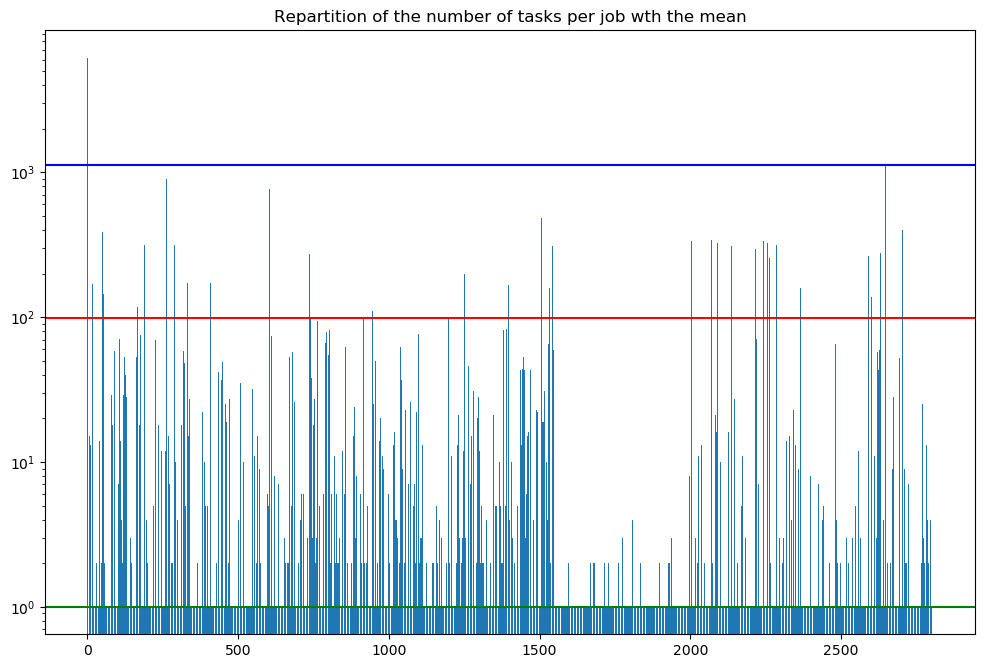

In [10]:
# Put it in a somewhat nice visualization

subset = jobs_list.sample(False, 0.1).countByValue().values()

# Bars: number of tasks for each job
plt.bar(np.arange(len(subset)), subset)

# Lines: the means (non corrected and corrected)
plt.axhline(y=low_mean, color='green', label="Lower mean")
plt.axhline(y=high_mean, color='blue', label="Higher mean")
plt.axhline(y=mean, color='red', label="Mean")

# A log scale to have a better representation (because some jobs have a really large number of tasks, 
# and a standard scale would break the visualization)
plt.yscale("log")

plt.title("Repartition of the number of tasks per job wth the mean")

plt.show()

On the graph shown above, we have represented the number of tasks for all of the studied jobs. The mean is designated by the red line, while the mean corrected with the standard derivation on lowest and highest bound is represented by the blue lines.

## Dataframe version

In [11]:
te = create_dataframe('task_events', EXEC_MODE, cloud)
te.show(5)

Will download at most 1 file(s) from task_events.
Polling bucket gs://clusterdata-2011-2/task_events
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_events] (1/500).
+----+------------+-------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|time|missing_info| job_id|task_index|machine_id|event_type|                user|scheduling_class|priority|cpu_request|memory_request|disk_space_request|different_machines_restriction|
+----+------------+-------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|   0|           2|3418309|         0|4155527081|         0|70s3v5qRyCO/1PCdI...|               3|       9|         NA|            NA|                NA|                            NA|
|   0|           2|3418309|         1| 329150663|         0|70s3v

In [12]:
task_per_job = te.select('job_id').groupBy('job_id').count()

task_per_job.select(
        F.round(F.mean('count'),2).alias('mean'), F.round(F.stddev('count'), 2).alias('std'),
        F.min('count').alias('min'), F.max('count').alias('max')
).show(10)

+-----+------+---+-----+
| mean|   std|min|  max|
+-----+------+---+-----+
|97.59|1033.4|  1|60438|
+-----+------+---+-----+



### Cluster execution

The `task_events` table consists of 500 files, which now makes *Job 2* interesting to run on a cluster, for performance and completeness of data:

**Data:**
* RDD:
```
mean: 215.24914732650402
std: 26646.453247846257
max: 16327120
min: 1
```

* DF:
```
+------+--------+---+--------+
|  mean|     std|min|     max|
+------+--------+---+--------+
|215.25|26646.47|  1|16327120|
+------+--------+---+--------+
```

**Time:**
* RDD cluster: 128.83 s
* DF cluster: 51.1 s

We are reassured to see the same results. We observe an even bigger discrepancy between the average number of task and the maximum: some job are composed up to 16 million tasks !! It must be quite a DAG...

We witnessed again an improved performance with the DF version.

# Job 3: What is the distribution of the number of jobs/tasks per scheduling class?

Each job and task possess a scheduling class, represented by a number between 0 and 3, that represents the sensibility to latency of the process. The higher the number is, the more the process is sensitive to latency (i.e., the process is a critical job that generates revenue...). This classification is used to affect the resource access policy on the local machine that executes the impacted process, and processes on the higher end of the classification tend to have higer priorities.

We would like to check the distribution of tasks and jobs for each class, in order to see what kind of processes these machines were treating the most.

We select the job id and the scheduling class for each task. Then, we do a combination by key, in order to count the number of unique tasks and unique jobs that were attributed to each scheduling class. This implies to define our own initialization, merging and combination functions used to manage the set of jobs and tasks associated to one particular scheduling class.

In [13]:
# The init, merge and combine functions for the operation that comes right after
# The goal is to count the number of tasks per job. And to have a distinct number of jobs
# with use a set
def init(new):
    job = set()
    job.add(new)
    return [job, 1]

def merge(old, new):
    old[0].add(new)
    return [old[0], old[1] + 1]

def combine(c1, c2):
    c1[0].union(c2[0])
    return [c1[0], c1[1]+c2[1]]

Number of Jobs and Tasks for each Scheduling Class:
	scheduling class [2], #job: 278, #task: 147272
	scheduling class [3], #job: 50, #task: 58985
	scheduling class [1], #job: 562, #task: 82065
	scheduling class [0], #job: 434, #task: 400242


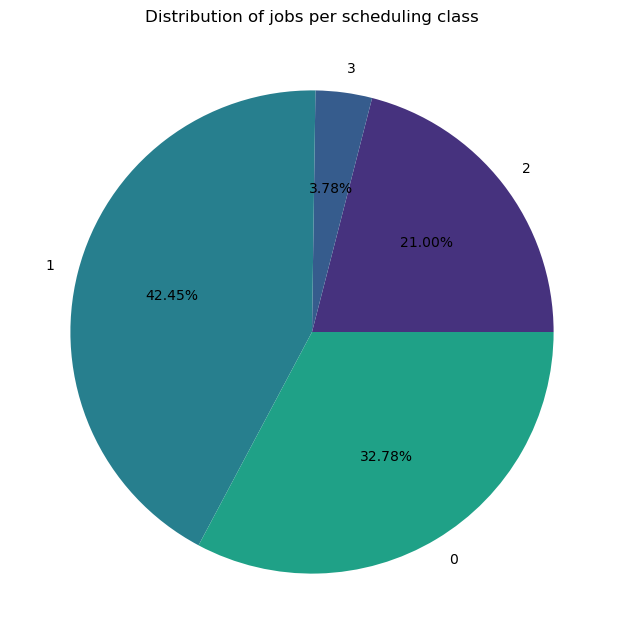

In [14]:
# Take the metrics that interests us
job_task_sched = task_events.select(['scheduling_class','job_id'])

# Combine the values by key
nb_jobs_tasks_per_sc = job_task_sched.combineByKey(init, merge, combine).mapValues(lambda x: (len(x[0]), x[1]))
print("Number of Jobs and Tasks for each Scheduling Class:")
print('\n'.join(f'\tscheduling class [{s}], #job: {j}, #task: {t}' for \
            s, (j,t) in nb_jobs_tasks_per_sc.collect()))

# Do a map to keep only the tuples (scheduling class, number of jobs)
sched_class_jobs = nb_jobs_tasks_per_sc.map(lambda x: (x[0], x[1][0]))

# Show the distribution of jobs for each scheduling class
# Done by converting the previous mapping to a Key -> Value structure that can be passed directly to the pie function
plt.pie(sched_class_jobs.collectAsMap().values(), labels=sched_class_jobs.collectAsMap().keys(), colors = colors, autopct='%.2f%%')
plt.title("Distribution of jobs per scheduling class")
plt.show()

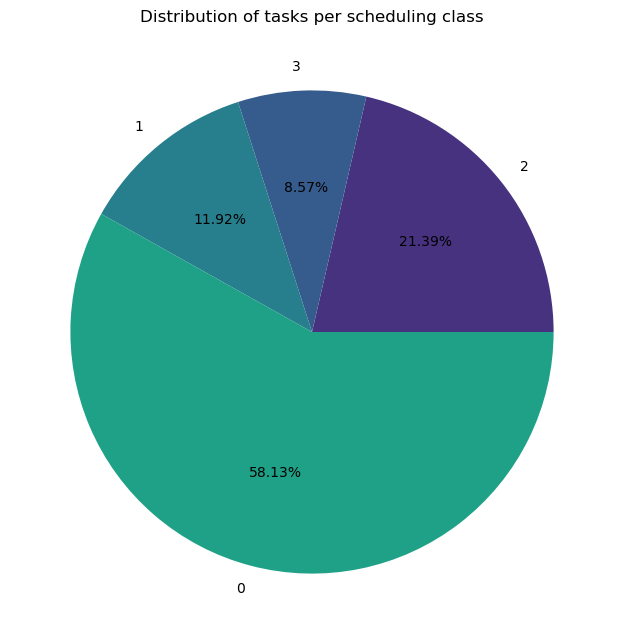

In [15]:
# Same for the tasks, by keeping the (scheduling class, number of tasks) tuples
sched_class_tasks = nb_jobs_tasks_per_sc.map(lambda x: (x[0], x[1][1]))

# And a pie chart as well
plt.pie(sched_class_tasks.collectAsMap().values(), labels=sched_class_tasks.collectAsMap().keys(), colors = colors, autopct='%.2f%%')
plt.title("Distribution of tasks per scheduling class")
plt.show()

We quickly see that most of the tasks were not really sensitive to latency, because they were assigned to the scheduling class number 0 (which holds everything that can be delayed for a while without any trouble).

Surprisingly, a great proportion of the jobs were attributed to the lowest scheduling classes, meaning that they were really not sensitive to latency.

## Dataframe version

We can see that the implementation is much more straightforward: built-in functions allow us to group on the scheduling class quite elegantly (and efficiently).

In [16]:
jts = te.select(
        te.scheduling_class, te.job_id, te.task_index
    )
jts.groupBy('scheduling_class').agg(
        F.countDistinct(jts.job_id), F.count(jts.task_index)
).orderBy(jts.scheduling_class).show()

+----------------+-------------+-----------------+
|scheduling_class|count(job_id)|count(task_index)|
+----------------+-------------+-----------------+
|               0|         1685|           400242|
|               1|         2519|            82065|
|               2|         1890|           147272|
|               3|          962|            58985|
+----------------+-------------+-----------------+



### Cluster execution

We can once again use fully the `task_events` table.

**Data:**
* RDD:
```
scheduling class [2], #job: 194497, #task: 11158598
scheduling class [0], #job: 257242, #task: 114598888
scheduling class [1], #job: 215099, #task: 18055014
scheduling class [3], #job: 5169, #task: 835788
```

* DF:
```
+----------------+-------------+-----------------+
|scheduling_class|count(job_id)|count(task_index)|
+----------------+-------------+-----------------+
|               0|       257242|        114598888|
|               1|       215099|         18055014|
|               2|       194497|         11158598|
|               3|         5169|           835788|
+----------------+-------------+-----------------+
```

**Time:**
* RDD cluster: 136.05 s
* DF cluster: 53.5 s

Even though numbers are bigger, we can see a similar distribution from the ones shown in the plots above. The elegant DF version beats the RDD version that we rewrote and rewrote. Despite the cool `combineByKey`, we cannot beat the engineers between the dataframe...

### Do tasks with low priority have a higher probability of being evicted?

Let's focus on the priority system. We wish to know if tasks having a low priority have a higher risk of being evicted in order to make place for the "more important" processses.

In [17]:
# Select the fields, and filter to keep the priority of every process at the exact moment it got evicted
task_priority_at_eviction = task_events.select(['event_type', 'priority'])\
        .filter(lambda x: x[0] == '2')\
        .map(lambda x: int(x[1]))

# Count the total number of evicted processes
total_evicted = task_priority_at_eviction.count()

# Print the distribution of each probability
number_of_evictions_foreach_priority = task_priority_at_eviction.countByValue()
print("Probability of being evicted for each priority listed:")
for k,v in sorted(number_of_evictions_foreach_priority.items()):
    print(f'\tpriority [{k}] = {round(v/total_evicted, 4)}')

Probability of being evicted for each priority listed:
	priority [0] = 0.9758
	priority [1] = 0.0103
	priority [2] = 0.0094
	priority [8] = 0.0001
	priority [9] = 0.0044
	priority [10] = 0.0001


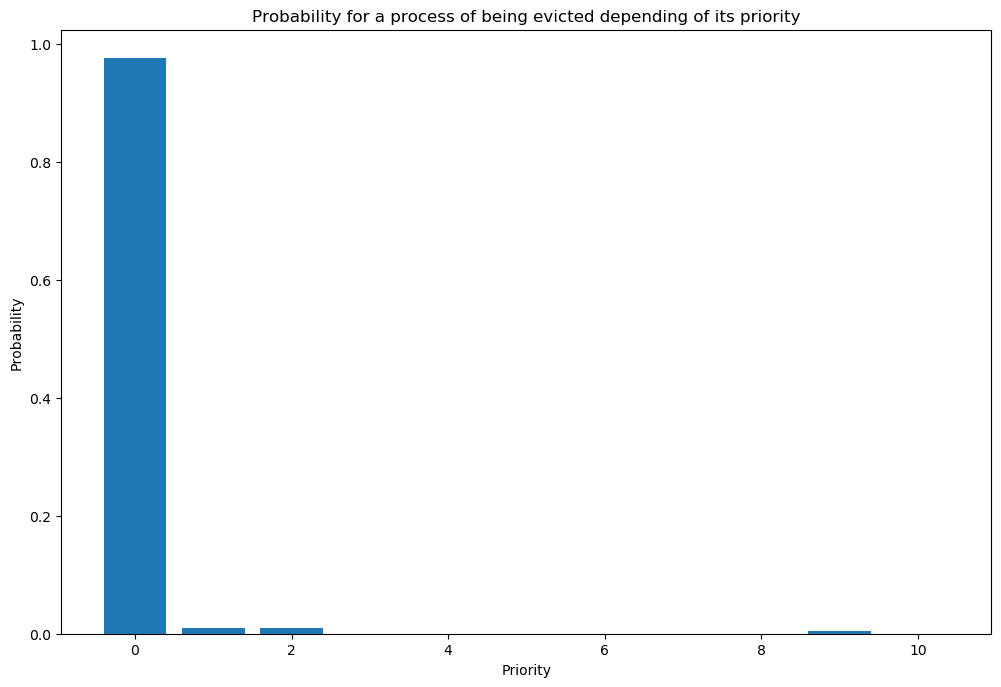

In [18]:
# Same as above, but this time in a nice graph

# Sort by priority and segregate in keys and values
sorted_number_of_evictions_foreach_priority = sorted(number_of_evictions_foreach_priority.items())
keys = [v[0] for v in sorted_number_of_evictions_foreach_priority]
values = [round(v[1]/total_evicted, 4) for v in sorted_number_of_evictions_foreach_priority]

# Print as a barchart
plt.bar(keys, values)
plt.xlabel('Priority')
plt.ylabel('Probability')
plt.title("Probability for a process of being evicted depending of its priority")
plt.show()

Indeed, lower-priority processes have a 97%-chance or higher of being evicted at any time to give way to more important processes. However, this probability drops to 1% and less as soon as the priority is equal to or above 1. 

### In general, do tasks from the same job run on the same machine ?

Now, we wonder if the jobs are usually running on the same machine, or if the tasks composing one job are being sent to different servers to be executed.

In [19]:
# We select all tuples of job id and machine id in the tasks events list.
# Then, we group by key, so that one line holds the number of unique machines on which the job was executed
nb_machines_per_job = task_events.select(['job_id', 'machine_id'])\
            .sample(False, 0.1)\
            .groupByKey()\
            .mapValues(lambda x: len(set(x)))\
            .map(lambda x: (x[1],x[0]))\
            .sortByKey()
machine_njob = nb_machines_per_job.countByKey()

Text(0.5, 1.0, 'Number of machines on which was executed each job')

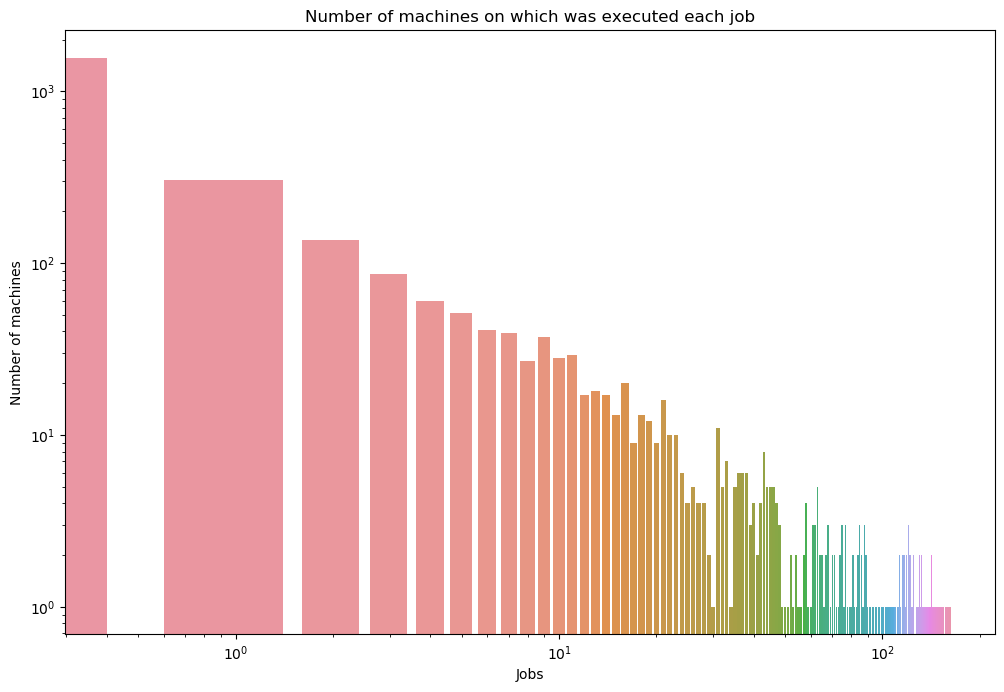

In [20]:
# We create our lists of keys and values
x=list(machine_njob.keys())
y=list(machine_njob.values())

# And then pass it to seaborn to create a barplot to have a global view
g = sns.barplot(x=x, y=y)

# There are a lot of jobs and they ran on multiple machines, so it is better to show it with a log scale
g.set_yscale("log")
g.set_xscale("log")

g.set_xlabel("Jobs")
g.set_ylabel("Number of machines")

g.set_title("Number of machines on which was executed each job")

### Are the tasks that request the more resources the one that consume the more resources?

To anwser this question, we need to rely on the "task_usage" logs. It holds, for each task, details about its execution, such as the start and end time, as well as the resources assigned to the task and the ones that were effectively consumed by the task.

We will process this analysis over the CPU and Memory usage, but as we don't have enough data, we will not consider the Disk IO metric.

Let's start by loading this table as a RDD.

In [21]:
task_usage = Table('task_usage', sc, EXEC_MODE, cloud)
task_usage.pprint(5)

,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787,2.861e-06,0.0001869,0.03967,0.0003567,2.445,0.007243,0,1,0
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.0003195,0.0007,0.06787,5.722e-06,0.0001879,0.03302,0.0009289,2.1,0.005791,0,1,0
2,600000000,900000000,3418314,0,3938719206,0.0003071,0.08044,0.09521,0.0002823,0.0006704,0.08044,4.768e-06,0.0001841,0.02377,0.0007858,5.588,0.0208,0,1,0
3,600000000,900000000,3418314,1,351618647,0.0003004,0.08044,0.09521,0.0005369,0.0008698,0.08044,9.537e-06,0.0001831,0.007919,0.002285,5.198,0.02038,0,1,0
4,600000000,900000000,3418319,0,431052910,0.0004606,0.07715,0.0874,0.0006247,0.0008516,0.07715,1.907e-06,0.0002041,0.005112,0.0002146,2.937,0.009449,0,1,0


### CPU usage

We start by studying the CPU usage. A good analysis would be to compare for each job and task the CPU quota requested by the process with the CPU that was actually used.

We first take the CPU requested by each job and task:

In [22]:
# Collect the cpu requested by each process identified by the tuple (job id, task id),
# and discard the Non Available values.
cpu_requests = task_events.select(['job_id','task_index','cpu_request'])\
                     .filter(lambda x: x[2] != 'NA')\
                     .map(lambda x: ((x[0],x[1]),float(x[2])))

We then get the CPU rates that were indeed used by each job and task:

In [23]:
# Same with the CPU rate
cpu_used = task_usage.select(['job_id','task_index','cpu_rate'])\
                   .filter(lambda x: x[2] != 'NA')\
                   .map(lambda x: ((x[0],x[1]),float(x[2])))

Finally, we do a join operation to link the requests and usages in a single data structure.

In [24]:
cpu_consumption = cpu_requests.join(cpu_used)

From the joined structure, we do a combine by key to find, for each job and task, each CPU request done and the CPU that was indeed used at the time.

In [25]:
def avg_init(row):
    return (row[0], row[1], 1)

def avg_merge(old, new):
    return (old[0]+new[0],old[1]+new[1],old[2]+1)

def avg_cmb(old, new):
    return (old[0]+new[0],old[1]+new[1],old[2]+new[2])

average_cpu_consumption = cpu_consumption.combineByKey(avg_init,avg_merge, avg_cmb)

Finally, we compute the average of all CPU requests and CPU usages for all tasks.

In [26]:
total_average_cpu_consumption = average_cpu_consumption.mapValues(lambda x: (x[0]/x[2],x[1]/x[2])).sortBy(lambda x: x[1][0], ascending=False)

This RDD is mapped in two different ones: the first holds the requested CPU for each identifier tuple (job, task), and the second the CPU that was actually used, again for each tuple.

In [27]:
jt_req = total_average_cpu_consumption.map(lambda x: (x[0], x[1][0]))
jt_real = total_average_cpu_consumption.map(lambda x: (x[0], x[1][1]))

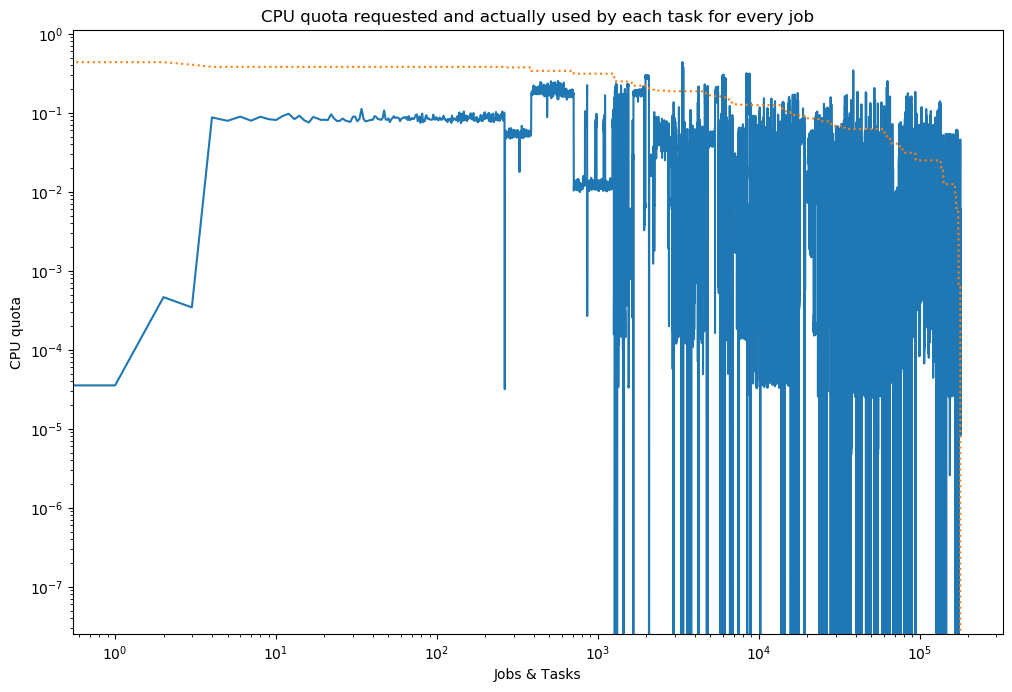

In [28]:
# Converting the tuples in integer identifiers.  We don't really need to know the job and task id for each point,
# so this is fine.
jt_req_coll = jt_req.collectAsMap()
job_task_id = np.arange(len(jt_req_coll.keys()))

# First plot: real CPU consumed
plt.plot(job_task_id, list(jt_real.collectAsMap().values()))

# Second plot: requested CPU
plt.plot(job_task_id, list(jt_req_coll.values()), linestyle='dotted')

plt.xlabel('Jobs & Tasks')
plt.ylabel('CPU quota')

# Same as the previous plots, use a log graph to avoid having a distorded graph
plt.xscale("log")
plt.yscale("log")

plt.title("CPU quota requested and actually used by each task for every job")

plt.show()

Above is a graph showing the CPU capacity requested by each task from each job and the CPU capacity that they have really consumed. As we can see, the most self-declared gluttonous are not ofteh the ones that are really consuming the most, as they only use a small fraction of what's available. 

Furthermore, we observe a huge fluctuation of the CPU capacity that is really consumed, where some processes are consuming nothing, and others are taking for themselves a large part of what the CPU can offer. The processes have in average almost always requested a CPU share above 0.1, but in reality they are either not taking it entirely, or in some cases they end up using more.

### Memory request

We now focus on memory (RAM) requests and real usage. The metrics that will be used are memory_request and canonical_memory_usage.
The process mostly remains the same as for the CPU.

In [29]:
# We collect the requested memory by each (job, task) process
mem_request = task_events.select(['job_id','task_index','memory_request'])\
                     .filter(lambda x: x[2] != 'NA')\
                     .map(lambda x: ((x[0],x[1]),float(x[2])))

# Same with the used memory
mem_usage = task_usage.select(['job_id','task_index','canonical_memory_usage'])\
                   .filter(lambda x: x[2] != 'NA')\
                   .map(lambda x: ((x[0],x[1]),float(x[2])))

# We join the data in one RDD
mem_consumed = mem_request.join(mem_usage)

# We compute the average for each (job, task)
average_mem_consumed = mem_consumed.combineByKey(avg_init, avg_merge, avg_cmb)\
                       .mapValues(lambda x: (x[0]/x[2],x[1]/x[2]))\
                       .sortBy(lambda x: x[1][0], ascending=False)

In [30]:
jt_mem_req = average_mem_consumed.map(lambda x: (x[0], x[1][0]))
jt_mem_real = average_mem_consumed.map(lambda x: (x[0], x[1][1]))

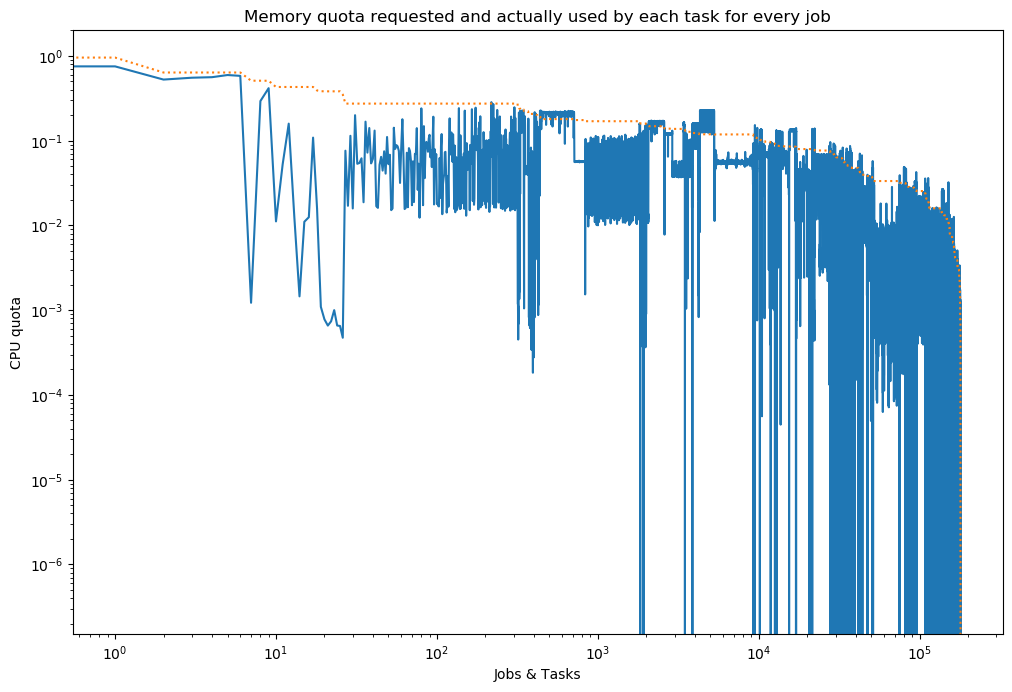

In [31]:
# Exactly the same as for the CPU once again
jt_mem_req_coll = jt_mem_req.collectAsMap()
job_task_id = np.arange(len(jt_mem_req_coll.keys()))

plt.plot(job_task_id, list(jt_mem_real.collectAsMap().values()), linestyle='solid')
plt.plot(job_task_id, list(jt_mem_req_coll.values()), linestyle='dotted')

plt.xlabel('Jobs & Tasks')
plt.ylabel('CPU quota')

plt.xscale("log")
plt.yscale("log")

plt.title("Memory quota requested and actually used by each task for every job")

plt.show()

We observe in the above graph that the memory requests are more on par with the real consumption than what we noticed for the CPU.

## Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

The objective of this analysis is to verify if consuming too much resources could lead a task to be evicted in favour of another one that is less glutoneous. We will collect the maximum CPU rate recorded for each job that went through the eviction step at least once, and try to see if there is a pattern behind these evictions.

In [32]:
# Select the maximum CPU rate consumed by each job
max_cpu_task = task_usage.select(['job_id', 'maximum_cpu_rate'])\
                         .mapValues(lambda x: float(x))\
                         .reduceByKey(max)


In [33]:
# Select the jobs that were evicted
filtered_task_events = task_events.select(['job_id', 'event_type']).filter(lambda x: x[1] == '2')

# Join both RDD to have the maximum CPU rate for each evicted job
max_cpu_evt = filtered_task_events.join(max_cpu_task).map(lambda x: (x[0], x[1][1])).collect()


Text(0.5, 1.0, 'Maximum CPU rate for Jobs that were evicted from a machine')

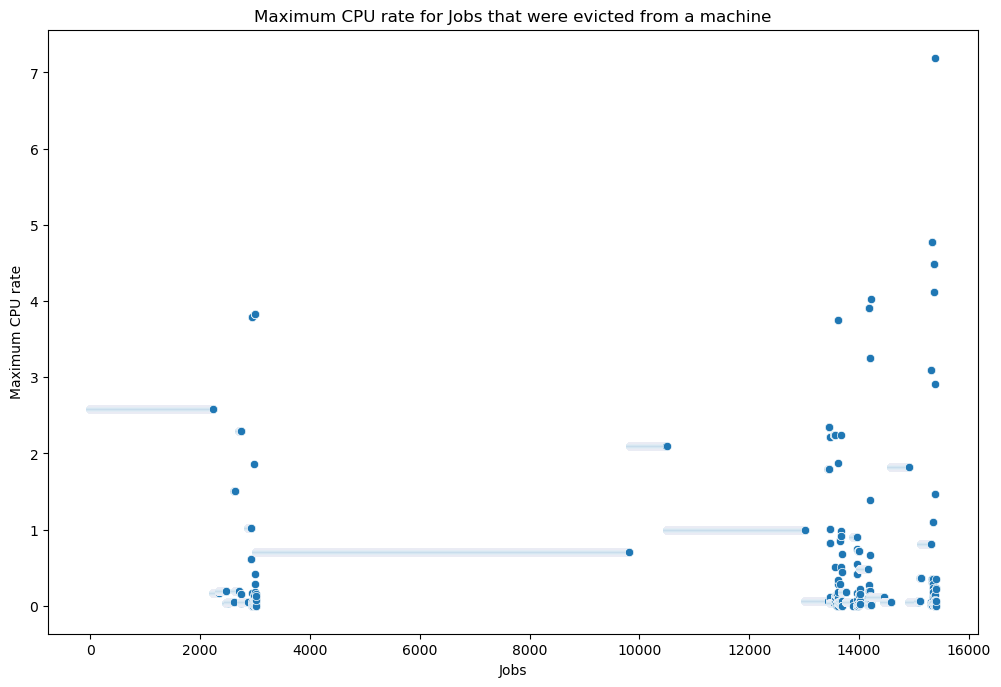

In [34]:
# Show the maximum CPU rate for each evicted job
g = sns.scatterplot(x=np.arange(len(max_cpu_evt)), y=[x[1] for x in max_cpu_evt])

g.set_xlabel("Jobs")
g.set_ylabel("Maximum CPU rate")

g.set_title("Maximum CPU rate for Jobs that were evicted from a machine")

The output is weird, are those values normal ? Needs more checks.

### Does the number of constraints of a task (including different-machine constraint) have an impact on the amount of time it spends in the PENDING state ?

#### With DataFrames

From the documentation of the data provided by Google, we know that several constraints can be put on one or multiple tasks to request specific characteristics (like having a task being executed on a different computer than the others, or requesting a particular resource...).

However, we wonder if putting too many of those constraints can lead to a task spending more time on a pending state than a task with no constraints. The code provided on the next lines tries to anwser this question.

In [137]:
te = create_dataframe('task_events', EXEC_MODE , cloud)

Will download at most 1 file(s) from task_events.
Polling bucket gs://clusterdata-2011-2/task_events
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_events] (1/500).


In [138]:
# Select the first timestamp at which all processes enter in PENDING state
# Only the first wait period in this state interests us
submit_status = te.select(te.job_id,te.task_index,te.event_type,te.time)\
    .filter(te.event_type == '0').select(te.job_id,te.task_index,te.time)\
    .withColumnRenamed('time', 'time_start_pending')

inpending = submit_status.groupBy(['job_id', 'task_index']).agg(F.min('time_start_pending').alias('time_start_pending'))

In [139]:
# Select the first timestamp at which all processes exit the PENDING state
outpending_status = te.select(te.job_id,te.task_index,te.event_type,te.time)\
    .filter(te.event_type.isin(['1', '3', '5', '6'])).select(te.job_id,te.task_index,te.time)\
    .withColumnRenamed('time', 'time_end_pending')
    
outpending = outpending_status.groupBy(['job_id', 'task_index']).agg(F.min('time_end_pending').alias('time_end_pending'))

In [140]:
# Join both sanitized dataframes together on job id and task id
fullpending = inpending.join(outpending, ['job_id', 'task_index'])

# Compute the delta for each occurence (time spent in pending state computed from both time_start_pending and time_end_pending)
fullpending_with_delta = fullpending.withColumn('delta_time', F.col('time_end_pending') - F.col('time_start_pending'))
fullpending_with_delta = fullpending_with_delta.select('job_id', 'task_index', 'delta_time')

# Quick output of non-null deltas to show how it looks like with interesting data
print("Showing a subset of (job, task) that have waited in PENDING state:")
fullpending_with_delta.filter(F.col('delta_time') > 0).show(10)

Showing a subset of (job, task) that have waited in PENDING state:
+----------+----------+-------------+
|    job_id|task_index|   delta_time|
+----------+----------+-------------+
| 515042969|         1|1.026166412E9|
|5495698530|         0|    2058110.0|
|5495698530|         1|    2058165.0|
|5664371117|       369|2.450274015E9|
|5664371117|       475|4.475973764E9|
|6218406404|      1006|1.736168175E9|
|6218406404|      1010|1.758708802E9|
|6218406404|      1022|1.805049496E9|
|6218406404|      1052|1.820799199E9|
|6218406404|      1082|1.875746714E9|
+----------+----------+-------------+
only showing top 10 rows



In [141]:
# Compute the mean delta time for each job
fullpending_with_delta = fullpending_with_delta.drop('task_index').groupBy('job_id').mean('delta_time')
print("Average delta time for every job computed. Showing subset:")
fullpending_with_delta.show(5)

Average delta time for every job computed. Showing subset:
+----------+---------------+
|    job_id|avg(delta_time)|
+----------+---------------+
|5007846463|            0.0|
|5556388735|            0.0|
|5943138316|            0.0|
|6127575571|            0.0|
|6137696559|            0.0|
+----------+---------------+
only showing top 5 rows



In [143]:
# Take constraints
tc = create_dataframe('task_constraints', EXEC_MODE, cloud)

Will download at most 1 file(s) from task_constraints.
Polling bucket gs://clusterdata-2011-2/task_constraints
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_constraints] (1/500).


In [145]:
# compute the mean number of constraints for each job
cons_jt = tc.select(tc.job_id, tc.task_index)
cons_jt = cons_jt.groupBy(cons_jt.job_id, cons_jt.task_index).count()
cons_jt = cons_jt.drop('task_index').groupBy('job_id').mean('count')

# Join the number of constraints with the delta time dataframe
full_df = fullpending_with_delta.join(cons_jt, on='job_id')
full_df = full_df.filter(full_df['avg(count)'] < 50).sort('avg(count)', ascending=False)

print("Subset of the full joined data:")
full_df.show(5)

Subset of the full joined data:
+----------+---------------+------------------+
|    job_id|avg(delta_time)|        avg(count)|
+----------+---------------+------------------+
| 515042954|            0.0|14.307692307692308|
|3990224152|            0.0|               8.0|
|2278253484|            0.0|               8.0|
|6239317302|            0.0|               8.0|
|5425205893|            0.0|               8.0|
+----------+---------------+------------------+
only showing top 5 rows



Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

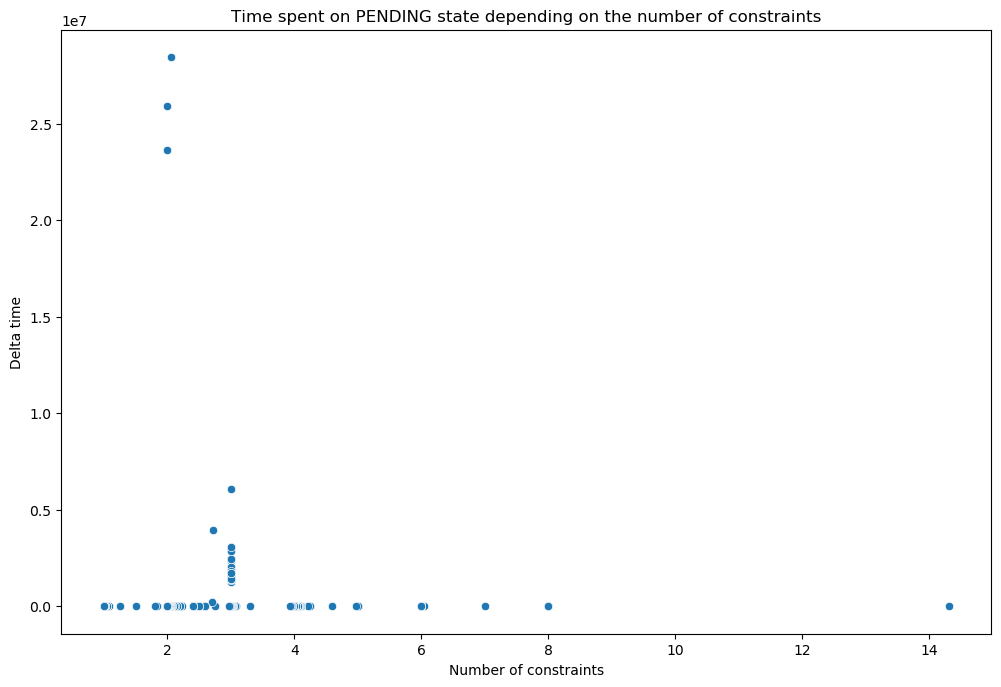

In [129]:
# And finally, display the graph
data = full_df.select('avg(delta_time)', 'avg(count)').toPandas()

g = sns.scatterplot(data=data, x='avg(count)', y="avg(delta_time)")

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")

From the graph shown above, we notice that despite having multiple constraints, a lot of tasks are not spending that much time in pending state (as their associated delta time is close to 0). This means that the number of these constraints does not influes directly on the time spent on pending.

Furthermore, we notice that some tasks that have no constraints were still put on hold for a while (maybe because all slots were filled ?), and at least one process that has several thousands of constraints was also forced to wait (it may be a mix of service unavailability and hard to satisfy constraints...)

#### With RDDs

The first implementation is using Pyspark's DataFrames. We now wish to do an implementation in RDD, in order to:

A- Be consistent with the other parts of the code written in this notebook

B- Prepare for the RDD vs DataFrame performance test that we will conduct on the cloud

In [149]:
# Select first SUBMIT transition for each job & task
submit_status = task_events.select(['job_id', 'task_index', 'event_type', 'time'])\
    .filter(lambda x: x[2] in ['0'])\
    .map(lambda x: (x[0]+', '+x[1], float(x[3])))

rdd_submit = submit_status.reduceByKey(min)
print("Subset of the reduced data:")
rdd_submit.take(5)

Subset of the reduced data:


[('3418309, 0', 0.0),
 ('3418309, 1', 0.0),
 ('3418314, 0', 0.0),
 ('3418314, 1', 0.0),
 ('3418319, 0', 0.0)]

In [150]:
outpending_status = task_events.select(['job_id', 'task_index', 'event_type', 'time'])\
    .filter(lambda x: x[2] in ['1', '3', '5', '6'])\
    .map(lambda x: (x[0]+', '+x[1], float(x[3])))

rdd_out = outpending_status.reduceByKey(min)
print("Subset of the reduced data:")
rdd_out.take(5)

Subset of the reduced data:


[('3418309, 0', 0.0),
 ('3418309, 1', 0.0),
 ('3418314, 0', 0.0),
 ('3418314, 1', 0.0),
 ('3418319, 0', 0.0)]

In [151]:
# Join everything and compute delta time for each job & task
rdd_deltatimes = rdd_submit.join(rdd_out).map(lambda x: (x[0].split(', ')[0], x[1][1] - x[1][0]))

# Average of the delta times for each job
rdd_deltatimes = rdd_deltatimes.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))

print("Subset of the averaged data:")
rdd_deltatimes.take(5)

Subset of the averaged data:


[('3418309', 0.0),
 ('3418314', 0.0),
 ('3418319', 0.0),
 ('3418324', 0.0),
 ('3418329', 0.0)]

In [152]:
# Load the task_constraints table
task_constraints = Table('task_constraints', sc, EXEC_MODE, cloud)

# Selects each occurence of constraint registered for each process
# Compute the number of constraints (= number of occurences)
task_constraints_per_job = task_constraints.select(['job_id', 'task_index'])\
    .map(lambda x: (x[0]+', '+x[1],1))\
    .reduceByKey(lambda a,b: a+b)\
    .map(lambda x: (x[0].split(', ')[0], x[1]))

# Compute the average number of constraints 
task_constraints_per_job = task_constraints_per_job.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))

print("Subset of the averaged data:")
task_constraints_per_job.take(5)



Subset of the averaged data:


[('3418314', 4.0),
 ('3418368', 4.0),
 ('3418375', 6.0),
 ('3418380', 4.0),
 ('3418400', 4.0)]

In [135]:
# Join the delta time and the number of constraints in one RDD
rdd_delta_constraints = rdd_deltatimes.join(task_constraints_per_job).filter(lambda x: x[1][1] < 50)
rdd_delta_constraints.take(5)

[('3418309', (0.0, 2.0)),
 ('3418314', (0.0, 4.0)),
 ('3418319', (0.0, 2.0)),
 ('3418324', (0.0, 2.0)),
 ('3418329', (0.0, 2.0))]

Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

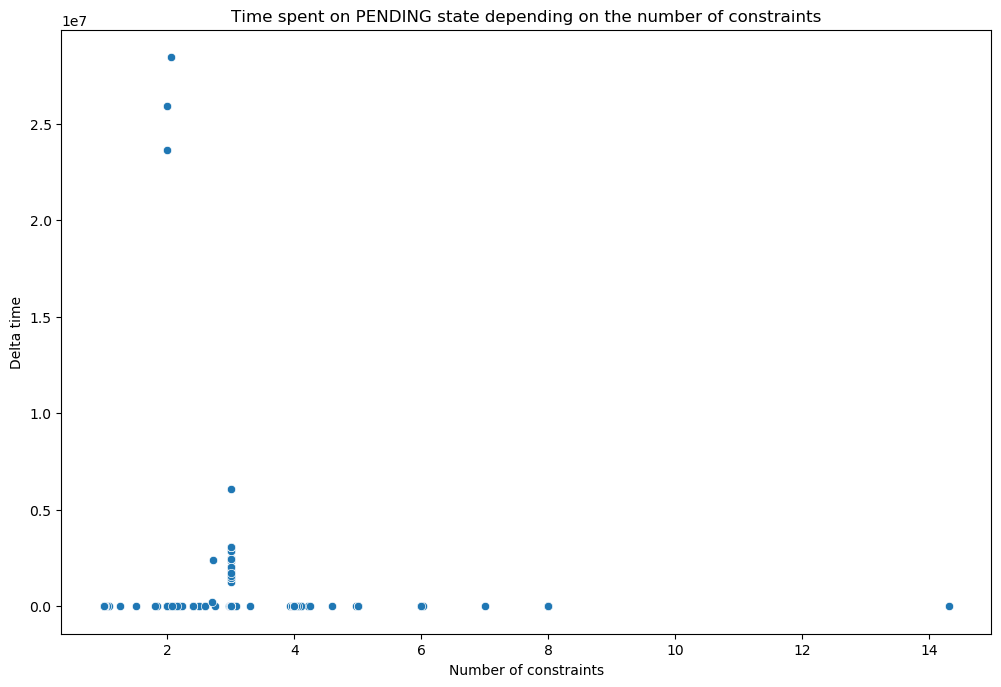

In [136]:
# Create the list of values from the last RDD
rdd_to_map = rdd_delta_constraints.collectAsMap()
deltatimes = [v[0] for v in rdd_to_map.values()]
constraints = [v[1] for v in rdd_to_map.values()]

# And then pass it to seaborn to create a barplot to have a global view
g = sns.scatterplot(x=constraints, y=deltatimes)

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")